# About Dataset

### Scenario
A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

### Goal
Evaluate A/B testing results and decide which marketing strategy works the best.

### Columns
* MarketID: unique identifier for market
* MarketSize: size of market area by sales
* LocationID: unique identifier for store location
* AgeOfStore: age of store in years
* Promotion: one of three promotions that were tested
* week: one of four weeks when the promotions were run
* SalesInThousands: sales amount for a specific LocationID, Promotion, and week

In [1]:
!pip install scikit-posthocs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, levene, kruskal
from statsmodels.stats.multicomp import MultiComparison
import scikit_posthocs as sp # Dunn's test.

plt.style.use("fivethirtyeight")

In [3]:
df_ = pd.read_csv("/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv")

In [4]:
df = df_.copy()

In [5]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


# Data Exploration

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MarketID,548.0,5.715328,2.877001,1.00,3.000,6.0,8.0000,10.00
LocationID,548.0,479.656934,287.973679,1.00,216.000,504.0,708.0000,920.00
AgeOfStore,548.0,8.503650,6.638345,1.00,4.000,7.0,12.0000,28.00
Promotion,548.0,2.029197,0.810729,1.00,1.000,2.0,3.0000,3.00
week,548.0,2.500000,1.119055,1.00,1.750,2.5,3.2500,4.00
SalesInThousands,548.0,53.466204,16.755216,17.34,42.545,50.2,60.4775,99.65


In [8]:
df.groupby("Promotion").agg({"SalesInThousands": ["count", "mean", "median", "std"]})

SalesInThousands                              
                     count       mean  median        std
Promotion                                               
1                      172  58.099012  55.385  16.553782
2                      188  47.329415  45.385  15.108955
3                      188  55.364468  51.165  16.766231

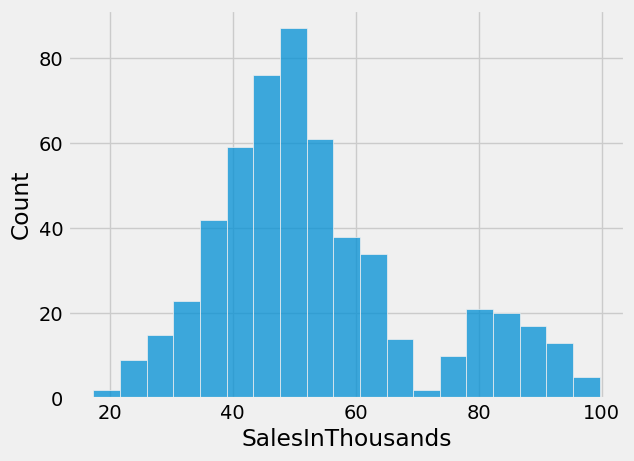

In [9]:
sns.histplot(data=df, x = "SalesInThousands")
plt.show()

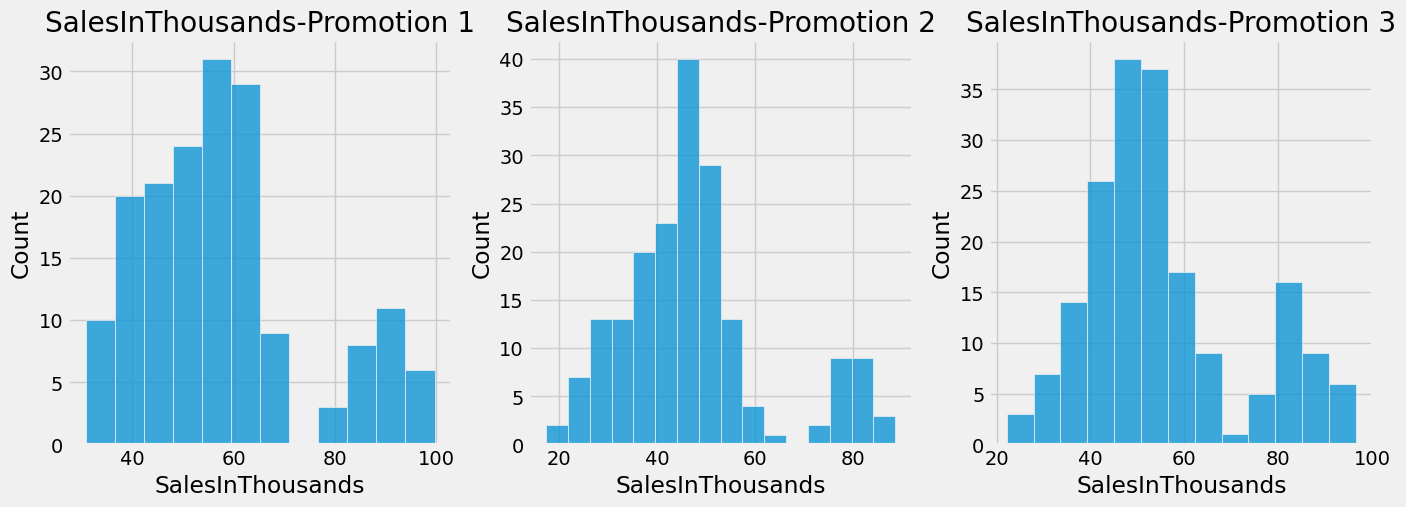

In [10]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

sns.histplot(data = df[df["Promotion"] == 1], x = "SalesInThousands", ax = axs[0])
sns.histplot(data = df[df["Promotion"] == 2], x = "SalesInThousands", ax = axs[1])
sns.histplot(data = df[df["Promotion"] == 3], x = "SalesInThousands", ax = axs[2])

axs[0].set_title("SalesInThousands-Promotion 1")
axs[1].set_title("SalesInThousands-Promotion 2")
axs[2].set_title("SalesInThousands-Promotion 3")

plt.show()

In [11]:
df.groupby(["Promotion", "MarketSize"]).agg({"SalesInThousands": ["count", "mean", "median", "std"]})

SalesInThousands                              
                                count       mean  median        std
Promotion MarketSize                                               
1         Large                    56  75.235893  72.835  15.497497
          Medium                   96  47.672604  47.425   8.067331
          Small                    20  60.162500  61.145   5.127279
2         Large                    64  60.322031  53.010  15.728529
          Medium                  108  39.114352  39.765   8.807407
          Small                    16  50.810625  51.600   5.869816
3         Large                    48  77.203958  82.345  14.400304
          Medium                  116  45.468879  46.295   8.091366
          Small                    24  59.514167  59.745   5.212687

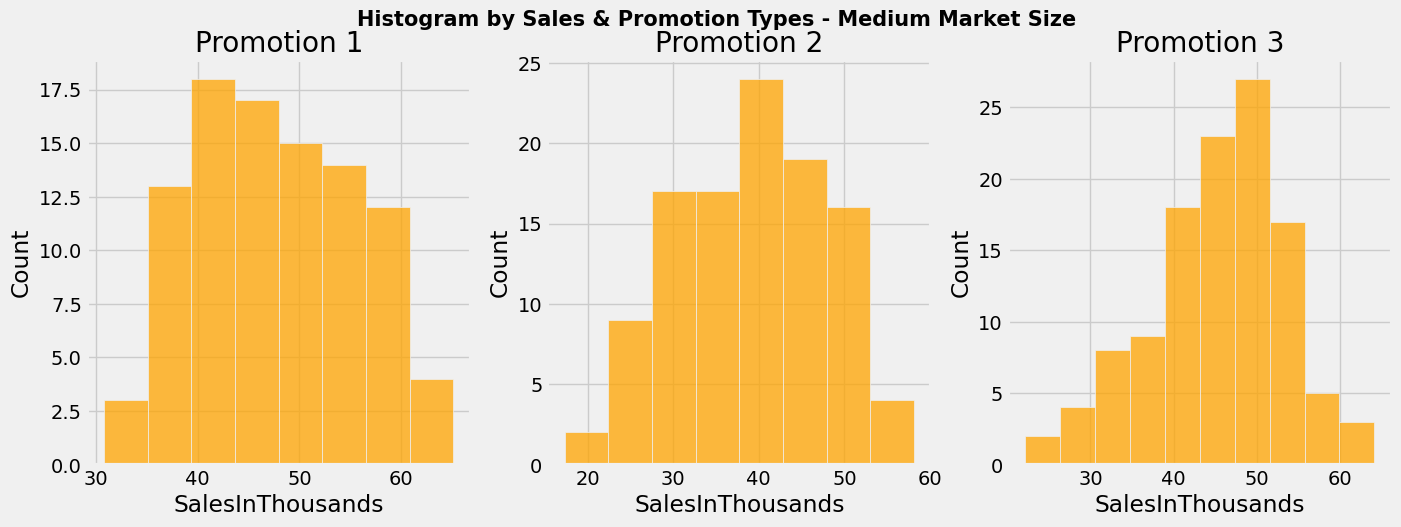

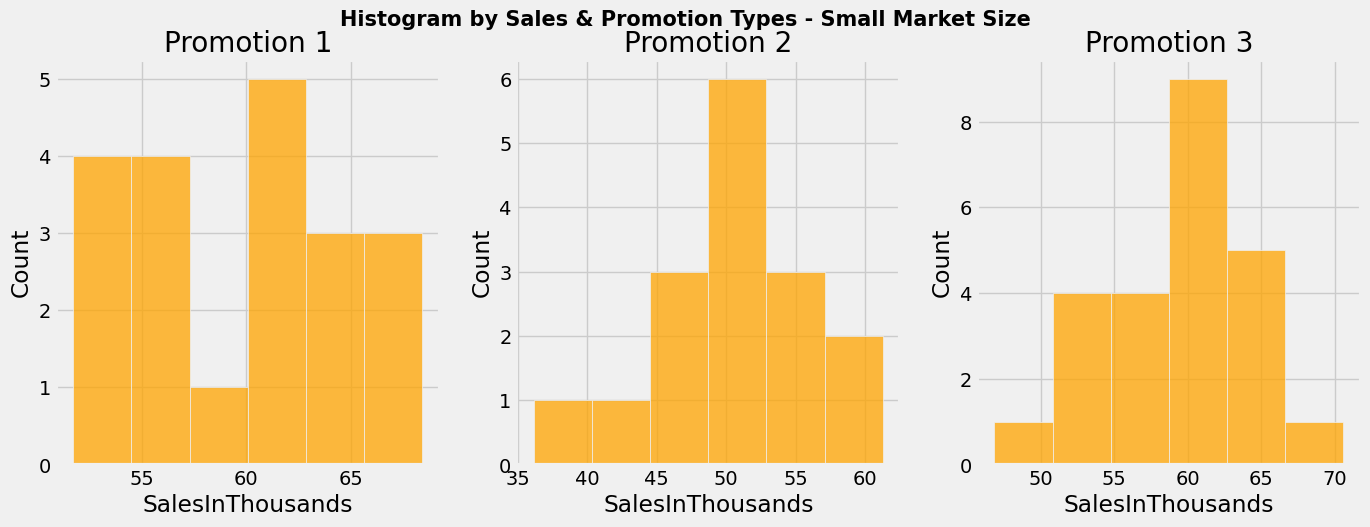

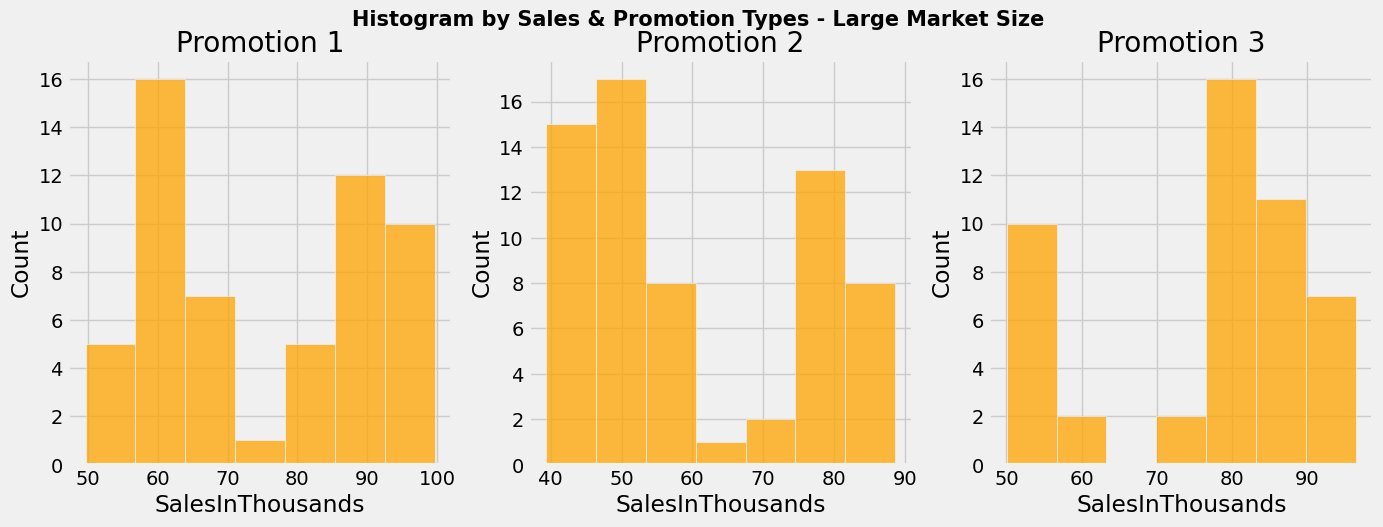

In [12]:
market_sizes = df["MarketSize"].unique()

for market_size in market_sizes:
    
    fig, axs = plt.subplots(1, 3, figsize = (15, 5))
    
    sns.histplot(data = df[(df["Promotion"] == 1) & (df["MarketSize"] == market_size)],x = "SalesInThousands", ax = axs[0], color = "orange")
    sns.histplot(data = df[(df["Promotion"] == 2) & (df["MarketSize"] == market_size)],x = "SalesInThousands", ax = axs[1], color = "orange")
    sns.histplot(data = df[(df["Promotion"] == 3) & (df["MarketSize"] == market_size)],x = "SalesInThousands", ax = axs[2], color = "orange")
    
    axs[0].set_title("Promotion 1")
    axs[1].set_title("Promotion 2")
    axs[2].set_title("Promotion 3")
    
    fig.suptitle(f'Histogram by Sales & Promotion Types - {market_size} Market Size', fontsize = 15, fontweight = 'semibold')
    plt.show()

### ANOVA(Analysis of Variance)

## 1. Normality Check

Shapiro-Wilk (W) test is used to test whether a random sample $X_1, X_2, ...., X_n$ follows a normal distribution or not. The null and altenative hypotheses are follows :

* $H_0$ : The distribution of the data set is normal.
* $H_1$ : The distribution of the data set is not normal.


To calculate the value of the W test statistic,

1. First, the data obtained from the sample is sorted from smallest to largest.

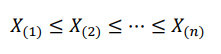

2. $s^2 = \sum_{i = 1}^n (X_{i} - \hat{X})^2$ ( variance )

3. If the sample size is even `n` = `2k` and if the sample size is odd `n`=`2k+1`, 

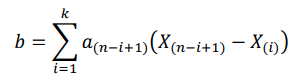

the b value is calculated Here the values of $a_{n-i+1} = -a_{i}$ are given in the respective table.

4. $W_h = b^2 / s^2 $ 

5. The percentile values 0.01, 0.02, 0.05, 0.10, 0.50, 0.90, 0.95, 0.98, and 0.99 are represented by $W_{tablo}$ in the table and can be found accordingly.

<b>Decision:</b>

If $W_h < W_{tablo} $ then $H_0$ hypothesis is rejected.

### QQ plot - Summary Information:

* In addition to statistical tests, graphical methods are also utilized to determine if a dataset follows a specific distribution. The most commonly used graphical method is the Q-Q plot.
* The Q-Q plot is a graphical method that relies on quantiles to determine whether a sample  $x_1, x_2, ..... , x_n$ comes from a normal distribution. It is widely used in practice.

The steps of the Q-Q plot method are as follows:

1. First, the data is sorted in ascending order.
2. Then, the sorted data is plotted against the tabulated values (z-scores) of the standard normal distribution on a coordinate system.
3. If the plotted sorted data aligns closely with a straight line on the coordinate system, indicating a linear distribution, it can be concluded that the data follows a normal distribution.

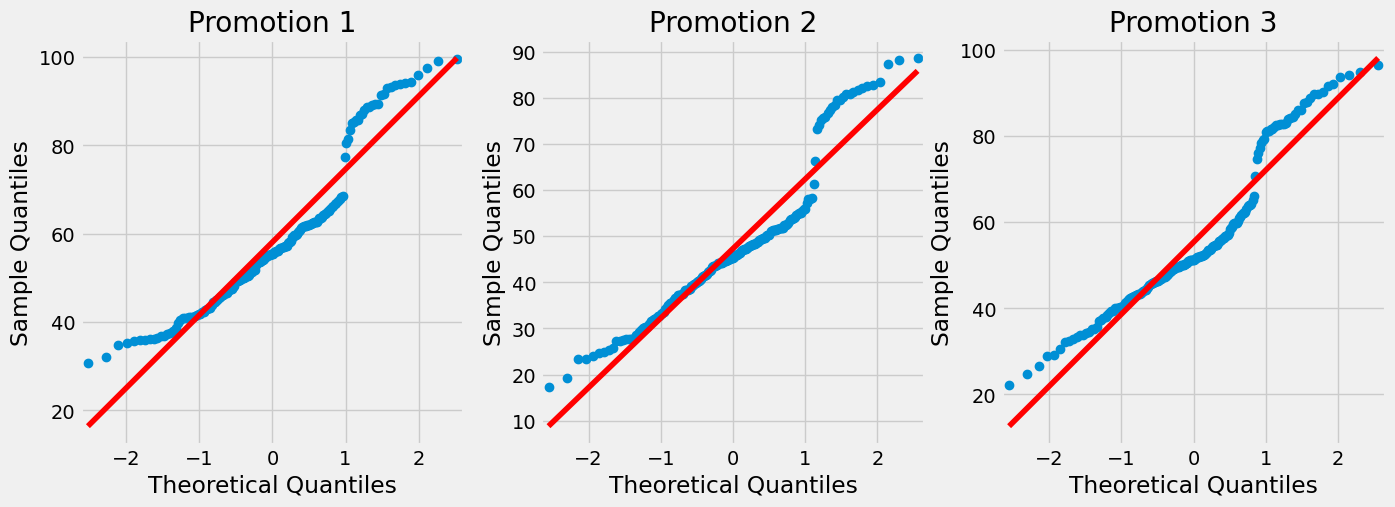

In [13]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

qqplot(df[df["Promotion"] == 1]["SalesInThousands"], line = "s", ax = axs[0])
qqplot(df[df["Promotion"] == 2]["SalesInThousands"], line = "s", ax = axs[1])
qqplot(df[df["Promotion"] == 3]["SalesInThousands"], line = "s", ax = axs[2])

axs[0].set_title("Promotion 1")
axs[1].set_title("Promotion 2")
axs[2].set_title("Promotion 3")

plt.show()

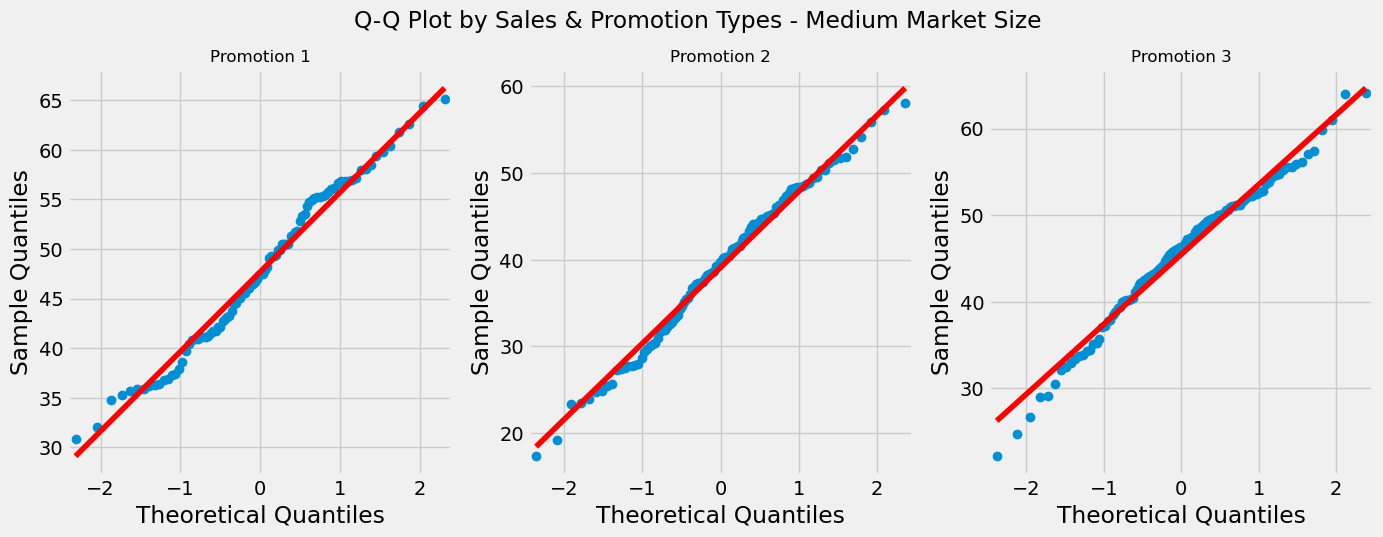

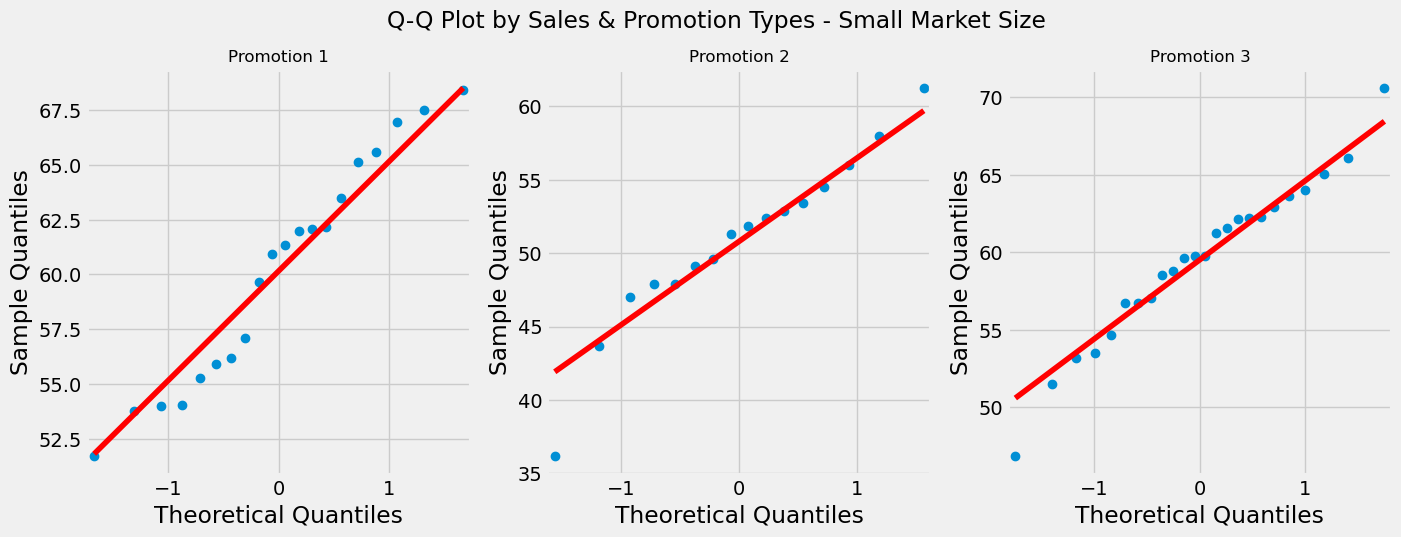

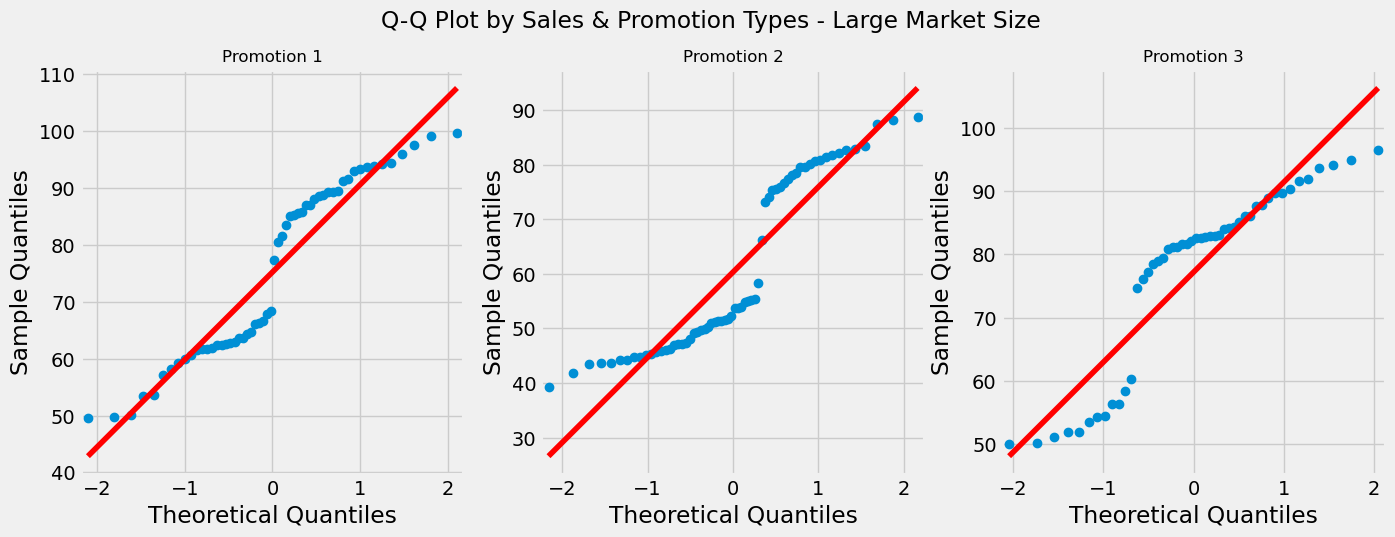

In [14]:
market_size = df["MarketSize"].unique()

for market in market_size:
    
    fig, axs = plt.subplots(1, 3, figsize = (15, 5))
    
    fig.suptitle(f'Q-Q Plot by Sales & Promotion Types - {market} Market Size', x = 0.5, y = 1.00)
    
    qqplot(df[(df["Promotion"] == 1) & (df["MarketSize"] == market)]["SalesInThousands"], line = "s", ax= axs[0])
    qqplot(df[(df["Promotion"] == 2) & (df["MarketSize"] == market)]["SalesInThousands"], line = "s", ax = axs[1])
    qqplot(df[(df["Promotion"] == 3) & (df["MarketSize"] == market)]["SalesInThousands"], line = "s", ax = axs[2])
    
    axs[0].set_title("Promotion 1", fontsize = 12)
    axs[1].set_title("Promotion 2", fontsize = 12)
    axs[2].set_title("Promotion 3", fontsize = 12)

In [15]:
# I will use shapiro() function from the scipy library.

promotions = df["Promotion"].unique()

for promotion in promotions:
    
    p_value = shapiro(df[df["Promotion"] == promotion]["SalesInThousands"])[1]
    
    print("Promotion : {} \t P-value : {} \t Reject H_0: {}".format(promotion, p_value, p_value<0.05))

Promotion : 3 	 P-value : 1.499518376135711e-08 	 Reject H_0: True
Promotion : 2 	 P-value : 5.456247009760773e-09 	 Reject H_0: True
Promotion : 1 	 P-value : 1.9772498305314912e-08 	 Reject H_0: True


<b>Interpretation : </b>
* The null hypothesis is rejected since p-value is less than 0.05. The normality assumption is not met.

### 2.) Variance Homogeneity - Levene Test

Many statistical testing procedures require that there is equal variance in samples. This is where the Levene test helps.

The Levene test checks whether several groups have the same variance in the population.

* $H_0$: Groups have equal variances.
* $H_1$: Groups have different variances.

If the p-value for the levene test is greater than 0.05, then the variances are not significantly different from each other. The homogeneity assumption is met.

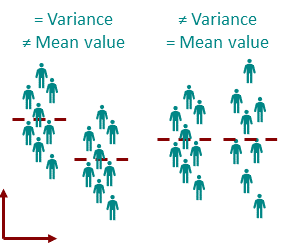

It is important to note that the mean values of the indiviual groups have no influence on the result, they may differ. A big advantage of Levene's test is that it is very stable against violations of the normal distribution. Therefore, Levene's test is used many statistics programs.

Furthermore the variance equality can also be checked graphically, this is usually done with a grouped box-plot or with a scatterplot.

<b>Assumptions of Levene Test:</b>
* independent observations.
* the test variable has metric scale level.

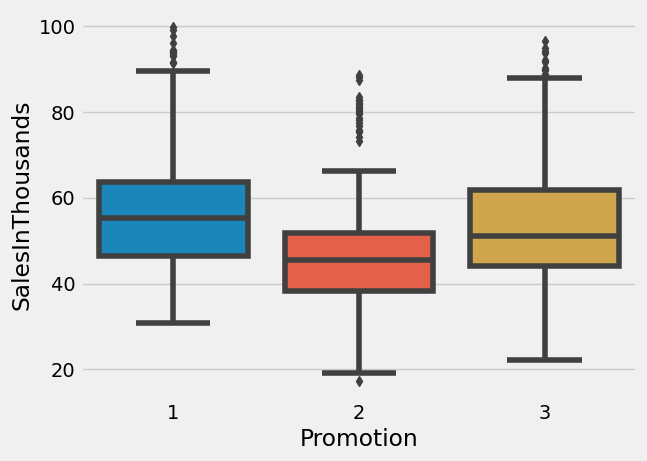

In [16]:
sns.boxplot(data = df, x = "Promotion", y = "SalesInThousands")

plt.show()

In [17]:
promotions = df["Promotion"].unique()

df.groupby("Promotion").agg({"SalesInThousands" : "var"})

,SalesInThousands
Promotion,
1,274.027688
2,228.280515
3,281.106494


In [18]:
# levene test for homogeneity.
test_stat, p_value = levene(df[df["Promotion"] == 1]["SalesInThousands"],
                            df[df["Promotion"] == 2]["SalesInThousands"],
                            df[df["Promotion"] == 3]["SalesInThousands"])

print("P-value : {} \t H_0 reject : {}".format(p_value, p_value<0.05))

P-value : 0.2817514565692118 	 H_0 reject : False


<b>Interpretation:</b>

* We fail to reject the null hypothesis since the p-value is greater than the significance level(alpha). There are no difference for variance in the groups. Homogeneity assumption is met.

### 3. ) Nonparametric ANOVA Test - Kruskal Wallis:

* The Kruskal-Wallis test(H-test) is a hypothesis test for multiple independent samples, which is used when the assumptions for one factor anova are not met.

* Since the Kruskal-Wallis test is a non-parametric test(also called a distribution-free test), the data used do not have to be normally distributed, in constrant to analysis of variance. The only requirement is that the data be ordinal scale.

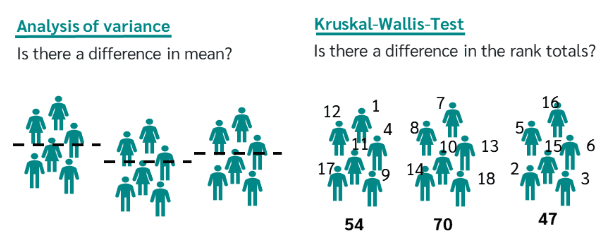

* In the Kruskal-Wallis test, ordinal variables are sufficient, since non-parametric tests do not use differences of the values, but the ranks(which value is larger, which is smaller). Therefore, the Kruskal-Wallis test is also often called "Kruskal-Wallis one-way ANOVA by rank test".

We should use Kruskal Wallis test because the normality assumption is not met.

In [19]:
test_stat, p_value = kruskal(
                            df[df["Promotion"] == 1]["SalesInThousands"], 
                            df[df["Promotion"] == 2]["SalesInThousands"], 
                            df[df["Promotion"] == 3]["SalesInThousands"]
)

print("P-value : {} \t H_0 reject : {}".format(p_value, p_value<0.05))

P-value : 2.6741866266697816e-12 	 H_0 reject : True


<b>Interpretation:</b>

p-value is less than 0.05. This means that at least one of the samples are different mean from others.

However we don't know which one is different. That's why post-hoc tests are used to make pairwise comparisons between groups to identify where the difference lie.

Such as Dunn's test and Tukey's HSD test are used more frequenctly than others.

### 4. ) Tukey's Test

Tukey's Honestly Significant Difference(HSD) test, also known as Tukey's range test or Tukey's pairwise comparisons, is a statistical method used to determine if there are significant differences between multiple group means. It is commonly applied after performing an ANOVA to compare means of three or more groups.

The Tukey's HSD test calculates a critical value called the minimum significant difference (or honestly significant difference) that represents the minimum difference between means needed to declare a significant difference at a specified level of confidence. 

The test compares all possible pairs of group means and identifies which pairs have mean differences larger than the minimum significant difference.

Here's a step-by-step overview of how the Tukey's HSD test works:

1. Perform an ANOVA: Start by conducting an ANOVA to determine if there are significant differences among the group means. The ANOVA provides the necessary information to compute the Tukey's HSD test.

2. Compute the Tukey's HSD value: The Tukey's HSD value is calculated using the formula:

HSD = q * sqrt(MSE / n),

where q is the critical value from the studentized range distribution, MSE is the mean square error from the ANOVA, and n is the number of observations in each group.

3. Compare mean differences: Calculate the difference between all possible pairs of group means and compare them to the Tukey's HSD value. If the difference between two means is larger than the HSD value, it indicates a significant difference between those groups.

4. Interpret the results: The Tukey's HSD test provides a table or summary output that shows which pairs of groups have significant differences. It typically includes information such as the group means, confidence intervals, and p-values.

In [20]:
comparison = MultiComparison(data = df["SalesInThousands"], groups = df["Promotion"])

tukey = comparison.tukeyhsd(0.05)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.0,-14.7738,-6.7654,True
1,3,-2.7345,0.2444,-6.7388,1.2697,False
2,3,8.0351,0.0,4.1208,11.9493,True


### 5. Dunn's Test

* If the results of a Kruskal-Wallis test are statistically significant, then it's appropriate to conduct <b>Dunn's Test</b> to determine exactly which groups are different.

* Dunn's test performs pairwise comparisons between each independent group and tells you which groups are statistically significantly different at some level of $ \alpha $ .

Hypothesis :

* $ H_0$ : There is no difference between groups( groups can be equal or unequal in size )
* $ H_1$ : There is a difference between groups.

<b> Bonferroni correction : </b>

* We know that when we see the significance level at 5%, we effectively accept that we would mistakenly reject a true null hypothesis 5 out of 100 times.
* When multiple tests or comparisons are performed simultaneously, the likelihood of obtaining a significant result by chance alone increases. 

<b>Family-wise Error Rate(FWER)</b> = The probability of making one or more type 1 errors when performing multiple hypothesis tests.

For a single test:

FWER = $ 1 - ( 1 - \alpha )^m$

But what if we perform more than one test ?

* Correction methods, also known as adjustment methods or procedures are applied to control type 1 error when conducting multiple comparion tests. Such as Bonferroni correction, Šidák correction, Holm-Bonferroni method, Benjamini-Hochberg procedure (False Discovery Rate control)

We will use Bonferroni correction which is the simplest and most popular approach.

Main idea of Bonferroni correction is that $\alpha$ divided by the number of tests m.

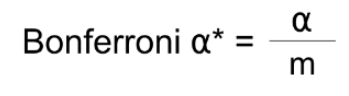

In [21]:
promotion_1 = df[df["Promotion"] == 1]["SalesInThousands"]
promotion_2 = df[df["Promotion"] == 2]["SalesInThousands"]
promotion_3 = df[df["Promotion"] == 3]["SalesInThousands"]

data_promotions = [promotion_1, promotion_2, promotion_3]

sp.posthoc_dunn(data_promotions, p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,6.461842e-12,1.458660e-01
2,6.461842e-12,1.000000e+00,7.083069e-07
3,1.458660e-01,7.083069e-07,1.000000e+00


<b>Interpretation: </b>
* p-value between promotion 1 and 2 : `6.461842e-12` and less than `0.05`. There is a difference between promotion 1 and promotion 2.
* p-value between promotion 3 and 2 : `7.083069e-07` and less than `0.05`. There is a difference between promotion 3 and promotion 2.
* p-value between promotion 1 and 3 : `1.458660e-01` and greater than `0.05`. There is no difference between promotion 1 and promotion 3.

Based on tukey's hsd and dunn's test:
* We suggest that promotion 1 and promotion 2 can apply since promotion 2 is less than other promotions.